In [30]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import datetime as dt
import tensorflow as tf
from sklearn.preprocessing import RobustScaler, MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tensorflow.keras import Sequential # Deep learning library, used for neural networks
from tensorflow.keras.layers import LSTM, Dense, Dropout # Deep learning classes for recurrent and regular densely-connected layers
from tensorflow.keras.callbacks import EarlyStopping # EarlyStopping during model training
import math
import mysql.connector

mydb = mysql.connector.connect(
    host = "localhost",
    user = "root",
    password = "",
    database ='etl'
)
 
# Creating an instance of 'cursor' class
# which is used to execute the 'SQL'
# statements in 'Python'
cursor = mydb.cursor()
 
# Show database tables
cursor.execute("SHOW TABLES")
 
for x in cursor:
  print(x)

def sql_upload(pd_dataframe):
    for index, row in pd_dataframe.iterrows():
        cursor.execute("INSERT INTO bitcoin (unix,date,symbol,open,high,low,close,Volume_BTC,Volume_USD) values(%s,%s,%s,%s,%s,%s,%s,%s,%s)",(row['unix'],row['date'],row['symbol'],row['open'],row['high'],row['low'],row['close'],row['Volume BTC'],row['Volume USD']))
        mydb.commit()
    print("Successfully uploaded to sql table")
    
    
df = pd.read_csv('csv/BTC-Daily.csv')
df

('bitcoin',)
('crypto',)


,unix,date,symbol,open,high,low,close,Volume BTC,Volume USD
0,1646092800,2022-03-01 00:00:00,BTC/USD,43221.71,43626.49,43185.48,43185.48,4.900629e+01,2.116360e+06
1,1646006400,2022-02-28 00:00:00,BTC/USD,37717.10,44256.08,37468.99,43178.98,3.160618e+03,1.364723e+08
2,1645920000,2022-02-27 00:00:00,BTC/USD,39146.66,39886.92,37015.74,37712.68,1.701817e+03,6.418008e+07
3,1645833600,2022-02-26 00:00:00,BTC/USD,39242.64,40330.99,38600.00,39146.66,9.127241e+02,3.573010e+07
4,1645747200,2022-02-25 00:00:00,BTC/USD,38360.93,39727.97,38027.61,39231.64,2.202852e+03,8.642149e+07
...,...,...,...,...,...,...,...,...,...
2646,1417478400,2014-12-02 00:00:00,BTC/USD,378.39,382.86,375.23,379.25,2.593576e+06,6.832530e+03
2647,1417392000,2014-12-01 00:00:00,BTC/USD,376.40,382.31,373.03,378.39,2.520662e+06,6.660560e+03
2648,1417305600,2014-11-30 00:00:00,BTC/USD,376.57,381.99,373.32,373.34,1.145567e+06,3.046330e+03
2649,1417219200,2014-11-29 00:00:00,BTC/USD,376.42,386.60,372.25,376.72,2.746157e+06,7.245190e+03


In [31]:
#Uploading to SQL 
#sql_upload(df)

In [32]:
df = pd.read_sql("SELECT * FROM bitcoin", con=mydb)
df

,unix,date,symbol,open,high,low,close,Volume_BTC,Volume_USD
0,1417132800,2014-11-28,BTC/USD,363.59,381.34,360.57,376.28,3.220878e+06,8.617150e+03
1,1417219200,2014-11-29,BTC/USD,376.42,386.60,372.25,376.72,2.746157e+06,7.245190e+03
2,1417305600,2014-11-30,BTC/USD,376.57,381.99,373.32,373.34,1.145567e+06,3.046330e+03
3,1417392000,2014-12-01,BTC/USD,376.40,382.31,373.03,378.39,2.520662e+06,6.660560e+03
4,1417478400,2014-12-02,BTC/USD,378.39,382.86,375.23,379.25,2.593576e+06,6.832530e+03
...,...,...,...,...,...,...,...,...,...
2646,1645747200,2022-02-25,BTC/USD,38360.93,39727.97,38027.61,39231.64,2.202852e+03,8.642149e+07
2647,1645833600,2022-02-26,BTC/USD,39242.64,40330.99,38600.00,39146.66,9.127241e+02,3.573010e+07
2648,1645920000,2022-02-27,BTC/USD,39146.66,39886.92,37015.74,37712.68,1.701817e+03,6.418008e+07
2649,1646006400,2022-02-28,BTC/USD,37717.10,44256.08,37468.99,43178.98,3.160618e+03,1.364723e+08


# **Preprosessing**

In [33]:
#df = pd.read_csv('/kaggle/input/btcinusd/BTC-Daily.csv')
# Removing all unessesary columns ( See Research )
df = df = df.drop(["Volume_BTC", "unix","Volume_USD", "symbol","open"], axis=1)
df['date'] = pd.to_datetime(df['date'])
df = df.sort_values(by='date')
df.index = df.pop("date")
df

,high,low,close
date,,,
2014-11-28,381.34,360.57,376.28
2014-11-29,386.60,372.25,376.72
2014-11-30,381.99,373.32,373.34
2014-12-01,382.31,373.03,378.39
2014-12-02,382.86,375.23,379.25
...,...,...,...
2022-02-25,39727.97,38027.61,39231.64
2022-02-26,40330.99,38600.00,39146.66
2022-02-27,39886.92,37015.74,37712.68


# **Standardization**

In [34]:
# Scaler for N-Dimensional Array
df_features = df.drop(['close'],axis=1)
df_np = df_features.to_numpy()
scaler = MinMaxScaler()
df_scaled = scaler.fit_transform(df_np, (-1,1))
df_scaled[0]

array([0.00244959, 0.00314943])

In [35]:
# Scaler for 1D array
df_close = pd.DataFrame(df['close'])
df_close_np = df_close.to_numpy()
to_inverse_scale = MinMaxScaler()
df_close_scale = to_inverse_scale.fit_transform(df_close_np)
df_close_scale

array([[0.00317937],
       [0.0031859 ],
       [0.00313575],
       ...,
       [0.55715655],
       [0.63826253],
       [0.63835898]])

# **Converting Data to 3 Dimensions **

In [36]:
x = [] # The features needed for prediction.
y = [] # The expected result.

for i in range(len(df_scaled)-6):
    x.append(df_scaled[i:i+6])

for i in range(len(df_close_scale)-1):
        y.append(df_close_scale[i][0])


# Converting to Numpy array for easier reading by the ML-Algorithm
X = np.array(x)
Y = np.array(y)




# **Splitting the Data (Train/Test)**

In [37]:
train_no = math.floor(len(X) * 0.7) # 70% for training, 30% For Testing
total_no = len(X) 
X_Train, Y_Train = X[:train_no][:train_no], Y[:train_no]
X_Test, Y_Test = X[train_no: total_no - 1], Y[train_no: total_no - 1]

In [38]:
print(X_Train.shape, Y_Train.shape)
print(X_Test.shape, Y_Test.shape)

(1851, 6, 2) (1851,)
(793, 6, 2) (793,)


In [39]:
X_Train, Y_Train = X[:train_no], Y[:train_no]
X_Test, Y_Test = X[train_no: total_no - 1], Y[train_no: total_no - 1]

# **Developing The Model**

In [40]:
model = Sequential()
# Three layers, Final Output is in an array of 10 predictions
model.add(LSTM(30, return_sequences=True, input_shape=(6,2)))
model.add(LSTM(25, return_sequences=True))
model.add(LSTM(20, return_sequences=False))
model.add(Dense(15))
model.add(Dense(10))
          

In [41]:
model.compile(optimizer='adam', loss='mean_squared_error') # Compling the Model

In [42]:
modeled = model.fit(X_Train, Y_Train, batch_size=1, epochs=10) # Training the model

Epoch 1/10
1851/1851 [==============================] - 17s 6ms/step - loss: 1.8814e-04
Epoch 2/10
1851/1851 [==============================] - 12s 6ms/step - loss: 4.1350e-05
Epoch 3/10
1851/1851 [==============================] - 12s 7ms/step - loss: 4.6702e-05
Epoch 4/10
1851/1851 [==============================] - 12s 7ms/step - loss: 4.2884e-05
Epoch 5/10
1851/1851 [==============================] - 13s 7ms/step - loss: 3.4353e-05
Epoch 6/10
1851/1851 [==============================] - 13s 7ms/step - loss: 3.7283e-05
Epoch 7/10
1851/1851 [==============================] - 13s 7ms/step - loss: 3.2167e-05
Epoch 8/10
1851/1851 [==============================] - 13s 7ms/step - loss: 3.3653e-05
Epoch 9/10
1851/1851 [==============================] - 13s 7ms/step - loss: 2.9955e-05
Epoch 10/10
1851/1851 [==============================] - 13s 7ms/step - loss: 3.3977e-05


# **Testing the Model**

In [43]:
predictions = model.predict(X_Test)
predictions = to_inverse_scale.inverse_transform(predictions) # Reverse the standardization.


25/25 [==============================] - 2s 4ms/step


In [44]:
# Putting the predictions in an array to convert into dataframe column later.
valid = []
for i in range(len(predictions)):
    valid.append(predictions[i][9]) # Using the final prediction in the array.
    

# **Validating the Results**

In [45]:
new_df = pd.DataFrame(df[train_no: total_no - 1])

new_df = new_df.drop(["high","low"], axis=1)

new_df['Prediction'] = valid


new_df

,close,Prediction
date,,
2019-12-23,7316.17,7102.134277
2019-12-24,7251.52,7014.655762
2019-12-25,7195.79,6998.446289
2019-12-26,7188.30,7032.118164
2019-12-27,7246.00,7019.802734
...,...,...
2022-02-18,39996.99,31481.089844
2022-02-19,40109.02,31298.630859
2022-02-20,38373.90,31039.041016


<AxesSubplot:xlabel='date'>

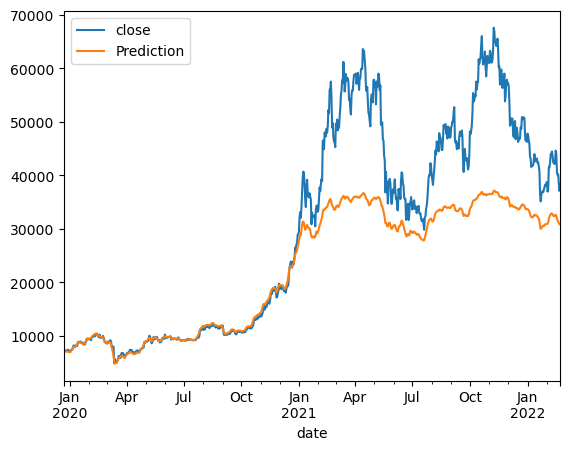

In [46]:
new_df.plot()

In [47]:
new_df.corr() # Accuracy around 99.5%

,close,Prediction
close,1.000000,0.973281
Prediction,0.973281,1.000000


In [48]:
test = X_Test[787:]

tests = model.predict(test)
tests =to_inverse_scale.inverse_transform(tests)
t = []
for i in range(len(tests)):
    t.append(tests[i][9])

t

1/1 [==============================] - 0s 16ms/step


[31913.428, 31481.09, 31298.63, 31039.041, 30845.316, 30789.107]